## Dataset Preparation and Model Initialization
To upload the model and dataset in Google Colab, you can use the following instructions:
1.   Download the Model and Dataset from [Github](https://github.com/Olivera2708/Space-formatting)
2.   Upload Files to Google Colab using the following code snippet

In [46]:
from google.colab import files

uploaded = files.upload()

Saving model.pth to model.pth


## Import Necessary Libraries
In this section, we will import all the libraries and modules required for our project. This includes libraries for data processing, model training, evaluation, and visualization.


In [36]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import re

## Make training and validation set
Define a function to load first 10 000 Java codes from the dataset.

In [37]:
columns_to_keep = ['code', 'formatted']

def load_data():
    df = pd.read_json("data.jsonl", lines=True)
    return df[columns_to_keep].head(10000)

Next function analyzes a given Java code snippet, identifying various components such as keywords, annotations, identifiers, operators, punctuation, literals, and whitespace using predefined regular expressions. It returns a list of tuples, each containing a token and its corresponding type index, facilitating further processing or analysis of the code.

In [38]:
def tokenize_and_classify(code):
    code = code.replace("  ", "\t")
    code = code.replace("\n\t", "\n")
    token_patterns = {
        "keyword": r'\b(public|private|protected|static|final|transient|volatile|abstract|synchronized|native|strictfp|interface|implements|extends|super|this|class|enum|package|import|return|void|if|else|for|while|do|switch|case|default|break|continue|try|catch|finally|throw|throws|assert|instanceof|new|instanceof|const|goto|boolean|byte|char|short|int|long|float|double)\b',
        "annotation": r'@\b[a-zA-Z_][a-zA-Z0-9_]*\b',
        "identifier": r'\b[a-zA-Z_][a-zA-Z0-9_]*\b',
        "operator": r'[+\-*/=<>!&|%^]',
        "punctuation": r'[(){}[\];,.]',
        "literal": r'\b\d+(\.\d+)?\b',
        "whitespace": r'[ \n\t]+',
    }


    combined_pattern = '|'.join(f'(?P<{key}>{value})' for key, value in token_patterns.items())
    tokens = []
    for match in re.finditer(combined_pattern, code):
        for token_type, token_value in match.groupdict().items():
            if token_value:
                if token_type == 'keyword':
                    tokens.append((token_value, 0))
                elif token_type == 'annotation':
                    tokens.append((token_value, 1))
                elif token_type == 'identifier':
                    tokens.append((token_value, 2))
                elif token_type == 'operator':
                    tokens.append((token_value, 3))
                elif token_type == 'punctuation':
                    tokens.append((token_value, 4))
                elif token_type == 'literal':
                    tokens.append((token_value, 5))
                elif token_type == 'whitespace':
                    tokens.append((token_value, 6))

    return tokens

To prepare the vocabulary for the model, we will define a function that builds a mapping of tokens to unique indices. This vocabulary will be essential for converting tokens into a format that the model can process.

In [39]:
def create_vocab(tokens, vocab_stoi, vocab_itos):
    for current_token, current_type in tokens:
        if current_type == 6:
            continue
        elif current_token not in vocab_stoi:
            vocab_stoi[current_token] = len(vocab_stoi)
            vocab_itos[len(vocab_itos)] = current_token

    return vocab_stoi, vocab_itos

To prepare the input and output data for the model, we will define a function that converts the tokenized code into a suitable format.

The input will consist of the token indices and their types, while the output will be the spacing types, which include no space, space, newline, and newline with tabs.

In [40]:
def tokenize_and_create_input_output(tokens, vocab_stoi):
    input = []
    output = []
    i = 0

    while i < len(tokens) - 1:
        current_token, current_type = tokens[i]
        next_token, next_type = tokens[i + 1]

        space_type = 0 #none

        if current_type == 6:
            i+=1
            continue

        try:
            if next_type == 6:
                whitespace = next_token
                next_token, next_type = tokens[i + 2]

                if '\n' == whitespace:
                    space_type = 3 #newline
                elif '\n' in whitespace and '\t' in whitespace:
                    space_type = 2 #newline+tab
                else:
                    space_type = 1 #space

            input.append((vocab_stoi[current_token], current_type))
            output.append(space_type)
        except Exception as e:
            pass
        i += 1

    if tokens[-1][1] != 6:
        input.append((vocab_stoi[tokens[-1][0]], tokens[-1][1]))
        output.append(0)
    return input, output

### Connecting All Components with a Unified Function

To integrate all the steps involved in preparing the dataset and creating input-output pairs for the model, we can define a function that ties together the tokenization, vocabulary creation, and input-output generation processes. This function will also reserve the `<UNK>` token for any unseen words during training.

In [41]:
def get_input_output_training(train_data):
    vocab_stoi = {"<UNK>": 0}
    vocab_itos = {0: "<UNK>"}
    input = []
    output = []

    for d in train_data["formatted"]:
        tokens = tokenize_and_classify(d)
        vocab_stoi, vocab_itos = create_vocab(tokens, vocab_stoi, vocab_itos)
        new_input, new_output = tokenize_and_create_input_output(tokens, vocab_stoi)

        input.extend(new_input)
        output.extend(new_output)

    return input, output, vocab_stoi, vocab_itos

In [42]:
data = load_data()
input, output, vocab_stoi, vocab_itos = get_input_output_training(data)
input = torch.tensor(input, dtype=torch.long)
output = torch.tensor(output, dtype=torch.long)
training_inputs, validation_inputs, training_outputs, validation_outputs = train_test_split(input, output, test_size=0.2, random_state=27)

Now we have our training and validation sets ready for use.

## Model

The `TokenSpacingModel` is a small Transformer neural network designed for predicting spacing classes between tokens in Java code.

Key Features:
- **Embeddings:** It incorporates two embedding layers for token and type representations, allowing the model to understand the relationships between different tokens and their roles.
- **Transformer Encoder:** The model uses a Transformer encoder to effectively capture the context and dependencies within token sequences, enabling better spacing predictions.
- **Output Layer:** A fully connected layer generates the predicted spacing classes, including options like no spacing, space, newline, and newline with tabs.

In [43]:
class TokenSpacingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim=64, num_token_types=6, hidden_dim=256, output_dim=4, num_heads=8, num_layers=6):
        super(TokenSpacingModel, self).__init__()

        self.token_embedding = nn.Embedding(vocab_size, embedding_dim)
        self.type_embedding = nn.Embedding(num_token_types, embedding_dim)

        self.transformer_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, batch_first=True),
            num_layers=num_layers
        )

        self.fc_type = nn.Linear(embedding_dim, output_dim)

    def forward(self, batch_input):
        tokens = batch_input[:, 0]
        types = batch_input[:, 1]

        token_embeddings = self.token_embedding(tokens)
        type_embeddings = self.type_embedding(types)

        combined_embeddings = token_embeddings + type_embeddings
        combined_embeddings = combined_embeddings.unsqueeze(1)

        transformer_output = self.transformer_encoder(combined_embeddings.permute(1, 0, 2))
        final_token_embedding = transformer_output[-1, :, :]

        type_pred = self.fc_type(final_token_embedding)
        return type_pred


### Loading the Model for Evaluation

In this step, we will load the pre-trained `TokenSpacingModel` to assess its performance on our validation dataset. Loading the model involves retrieving its state dictionary from a saved checkpoint and preparing it for evaluation. This allows us to measure how well the model can predict the spacing between tokens based on the learned representations.

In [44]:
def load_model(model_class, vocab_size, model_path, device):
    model = model_class(vocab_size)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()
    return model

In [47]:
vocab_size = len(vocab_stoi)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

code_model = TokenSpacingModel(vocab_size).to(device)
loss_fn_type = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(code_model.parameters(), lr=0.001)

code_model = load_model(TokenSpacingModel, vocab_size, "model.pth", device)

<ipython-input-44-3dc066330c23>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path, map_location=device))


## Confusion Matrix Visualization

The `plot_confusion_matrix` function visualizes the performance of the model by displaying a confusion matrix. A confusion matrix is a table that allows us to see the number of correct and incorrect predictions made by the model across different classes.

This function takes two parameters: `true_labels`, which represent the actual labels, and `pred_labels`, which are the predicted labels from the model. The matrix is plotted using seaborn’s heatmap for better clarity, with annotations indicating the number of predictions for each class. This visualization helps in understanding where the model is performing well and where it might be misclassifying tokens.

In [48]:
def plot_confusion_matrix(true_labels, pred_labels):
    cm = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix of Spacing Type Predictions')
    plt.show()

## Evaluation

The `evaluate` function assesses the performance of the trained model on the evaluation dataset. It processes the input data in batches and calculates both top-1 and top-3 accuracy metrics to determine how often the correct spacing type is predicted. Additionally, it visualizes the results using a confusion matrix, which provides insights into the model's performance across different classes.

Top-1 Accuracy for Spacing Type: 80.30%
Top-3 Accuracy for Spacing Type: 99.89%


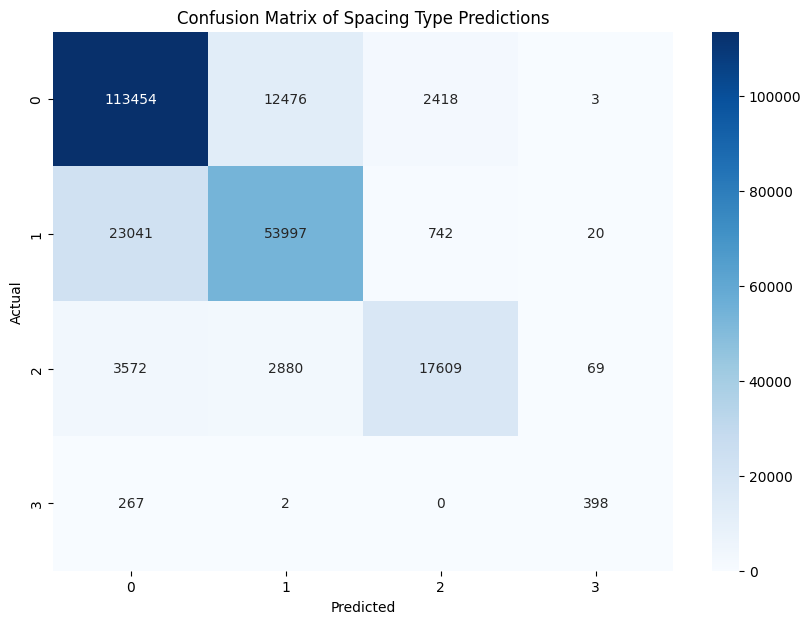

In [50]:
def evaluate(model, eval_inputs, eval_outputs, batch_size, device, length_threshold=0.1):
    model.eval()
    dataset = TensorDataset(eval_inputs, eval_outputs)
    dataloader = DataLoader(dataset, batch_size=batch_size)

    correct_type_top1 = 0
    correct_type_top3 = 0
    total_type = 0

    all_labels = []
    all_predictions = []

    with torch.no_grad():
        for input_batch, output_batch in dataloader:
            input_batch, output_batch = input_batch.to(device), output_batch.to(device)

            spacing_type_pred = model(input_batch)

            _, top3_pred_type = torch.topk(spacing_type_pred, 3, dim=1)

            top1_pred_type = top3_pred_type[:, 0]
            correct_type_top1 += torch.sum(top1_pred_type == output_batch).item()

            correct_type_top3 += torch.sum(torch.isin(output_batch, top3_pred_type)).item()

            total_type += len(input_batch)

            all_labels.extend(output_batch.cpu().numpy())
            all_predictions.extend(top1_pred_type.cpu().numpy())

    top1_accuracy_type = correct_type_top1 / total_type * 100
    top3_accuracy_type = correct_type_top3 / total_type * 100

    print(f"Top-1 Accuracy for Spacing Type: {top1_accuracy_type:.2f}%")
    print(f"Top-3 Accuracy for Spacing Type: {top3_accuracy_type:.2f}%")
    plot_confusion_matrix(all_labels, all_predictions)

evaluate(code_model, validation_inputs, validation_outputs, batch_size, device)

## Results
In this section, we assess the performance of our trained Transformer model on Java code snippets, specifically evaluating its ability to predict spacing between tokens.

### Accuracy Metrics
- **Top-1 Accuracy**: 80.30%
- **Top-3 Accuracy**: 99.89%

These results demonstrate that the model is highly effective at predicting the correct spacing between consecutive tokens in Java code.

### Confusion Matrix
The confusion matrix above provides a visual representation of the model's performance, illustrating the distribution of correct and incorrect predictions across various spacing classes. This allows for a deeper understanding of where the model excels and where improvements may be needed.